# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Winter term 2021/22
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Due date: **Tue, 07. Dec 21, at noon**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [3]:
# TODO import utils.py
from data_fetch import *

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [4]:
# TODO define device
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device = get_device()
# device = torch.device('cpu')
# print(device)
# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device GeForce GTX 1650
12 CPUs available


In [5]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders

In [6]:
trainset, testset, mean, std = grab_data(data_dir)
trainset, valset = generate_train_val_data_split(trainset)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=batch_size, num_cpus=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [7]:
# TODO define loss function
loss_function = torch.nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

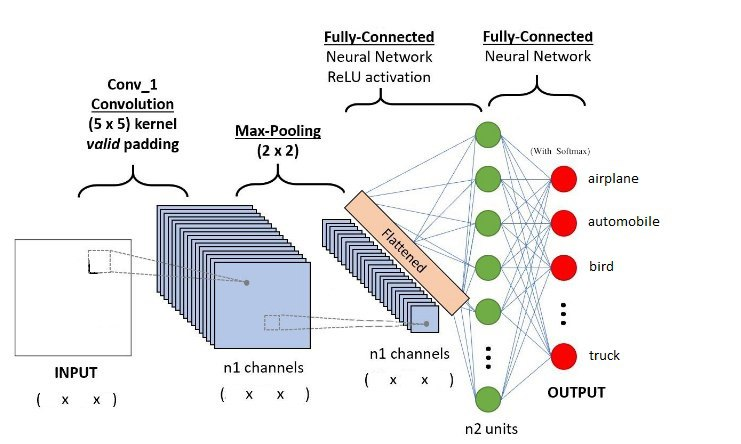

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps? 
- What are the dimensions after pooling?
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

<b>

*   The input dimensions are 256 (batch size) * 3 (channels) * 32 (height) * 32 (width).<br/>
*   The dimensions of the feature maps are (256 * ) 32 * 28 * 28 with 32 feature channels and a shrinkage of four pixels in height and width respectively because of the kernel size of 5 * 5 with stride one and no ("valid") padding.<br/>
*   The dimensions after pooling are (256 * ) 32 * 14 * 14. The dafault stride is equal to the kernel size.<br/>
*   There are n1 = 32 feature channels and n2 = 512 units between the linear layers. <br/>
*   The number of parameters for conv_1 is 32 * 5 * 5 * 3 = 2400.

</b>

In [8]:
# TODO define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1);
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(32 * 14 * 14, 512)
        self.linear2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        return x
        

In [9]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            early_stopper.early_stop = [epoch_val_acc, model]
            if early_stopper.early_stop is True:
              break
            # raise NotImplementedError

            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        raise NotImplementedError

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

In [10]:
# TODO train and plot
model = CNN().to(device)
epochs = 10
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [11]:
train_loss, val_loss, train_accuracy, val_accuracy, confusion_matrix = run_training(model=model, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader)

Finished training after 146 seconds.


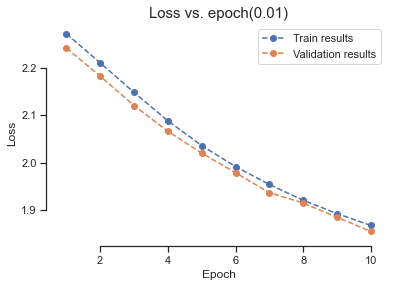

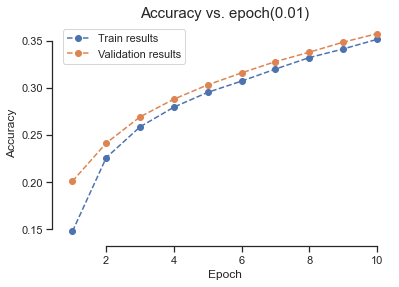

In [12]:
plot('Loss vs. epoch(0.01)', 'Loss', train_loss, val_loss)
plot('Accuracy vs. epoch(0.01)', 'Accuracy', train_accuracy, val_accuracy)

In [13]:
def print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy):
    print("="*30)
    print("Max Accuracy = {}, Epoch= {}".format(max(train_accuracy),np.array(train_accuracy).argmax()))
    print("="*30)
    print("Min Loss = {}, Epoch= {}".format(min(train_loss),np.array(train_loss).argmin()))

In [14]:
print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy)

Max Accuracy = 0.351275, Epoch= 9
Min Loss = 1.8672313386467612, Epoch= 9


#### **TODO**
Compare results to MLP. What can you observe?

**For MLP the plot gets flattened with increase in epochs whereas for CNN the plot is steadily improving with increase in number of epochs**

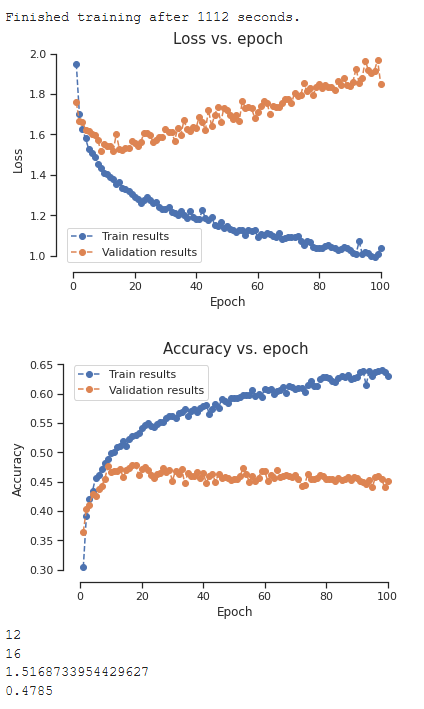

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [15]:
# TODO train and plot
epochs = 60
train_loss_60, val_loss_60, train_accuracy_60, val_accuracy_60, confusion_matrix_60 = run_training(model=model, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader)

Finished training after 795 seconds.


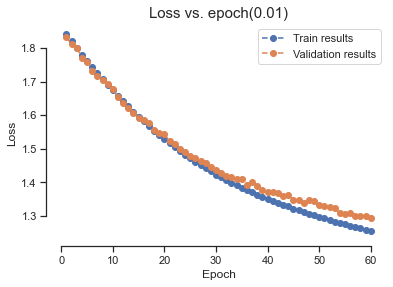

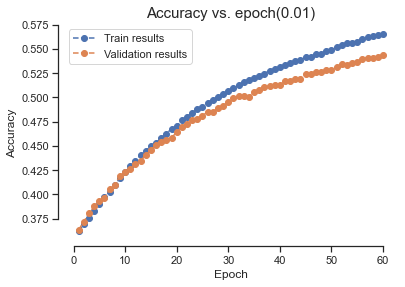

In [16]:
plot('Loss vs. epoch(0.01)', 'Loss', train_loss_60, val_loss_60)
plot('Accuracy vs. epoch(0.01)', 'Accuracy', train_accuracy_60, val_accuracy_60)

In [17]:
print_accuracy_loss(train_loss_60, val_loss_60, train_accuracy_60, val_accuracy_60)

Max Accuracy = 0.56575, Epoch= 59
Min Loss = 1.2533918345809743, Epoch= 59


#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**1. Since the max accuracy is attained in the last couple of epochs, hence the loss can be decreased further by increasing the number of epochs.**<br/>
**2. Introducing more layers to the model.**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

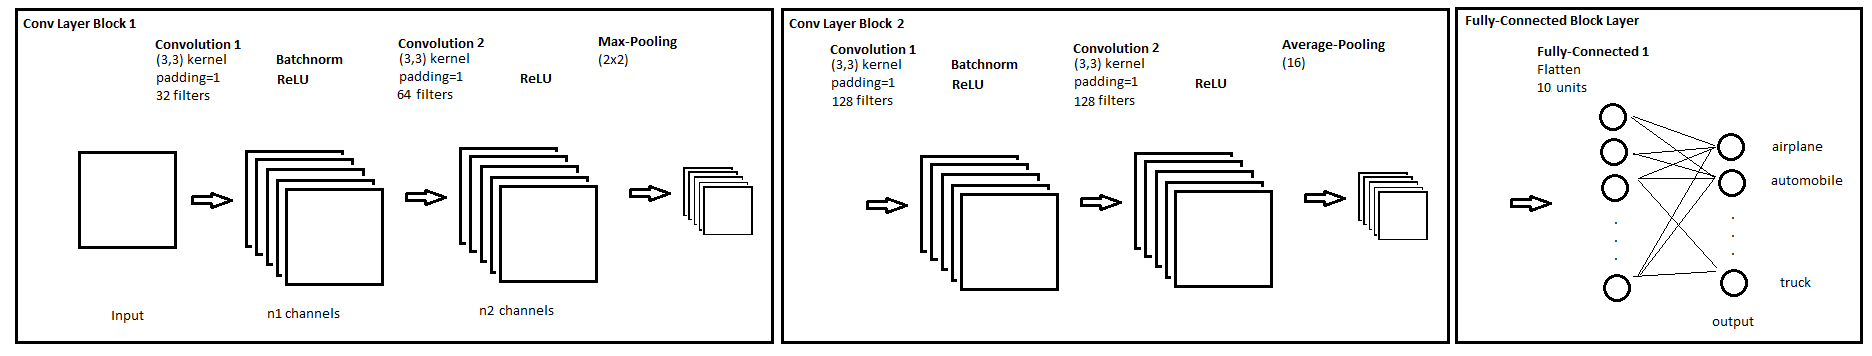

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

<b>

*   Padding refers to additional zero pixels around the input images. With "valid" padding there are no zero pixels added which results in a shrinkage of the image of "kernel size - 1" in height and width. With "same" padding the additional zero pixels level out the shrinkage exactly.<br/>
*   Padding = 1 means that there is a frame with a thickness of one pixel is added around the input image. With a 3 * 3 kernel size this corresponds to "same" padding.<br/>
*   After the first conv layer we have feature maps of dimensions (256 * ) 32 * 32 * 32.<br/>
*   After the second conv layer we have feature maps of dimensions (256 * ) 64 * 32 * 32.<br/>
*   The receptive field size after the first two convultions is 5 * 5.<br/>
*   Due to the both pooling procedures we have a feature map size of 1 * 1 and 128 channels and therefore a flattened input of length 128.<br/>
*   3 * 3 * 3 * 32 + 32 * 3 * 3 * 64<br/>
    864 + 18432<br/>
    19296
</b>

In [18]:
#TODO define model 2
class MultiCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ######### Block 1 #########
        self.b1c1 = nn.Conv2d(3, 32, 3, 1, 1);
        self.b1c1bn = nn.BatchNorm2d(32)
        self.b1c2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.poolb1 = nn.MaxPool2d(2)
    
        ######### Block 2 #########
        self.b2c1 = nn.Conv2d(64, 128, 3, 1, 1)
        self.b2c1bn = nn.BatchNorm2d(128)
        self.b2c2 = nn.Conv2d(128, 128, 3, 1, 1)
        self.poolb2 = nn.AvgPool2d(16)

        ######### Fully Connected Block #########
        self.linear1 = nn.Linear(128*1*1, 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.poolb1(F.relu(self.b1c2(self.b1c1bn(self.b1c1(x)))))
        x = self.poolb2(F.relu(self.b2c2(self.b2c1bn(self.b2c1(x)))))
        x = torch.flatten(x,1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        return x

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

<b>
1. Better accuracy was attained in a lower number of epochs<br/>
2. A more complex CNN allows to fit more complex functions due to introduction of several parameters. 
</b>

In [19]:
# TODO train and plot
multi_model = MultiCNN().to(device)
epochs = 30
lr = 0.1
optimizer = torch.optim.SGD(multi_model.parameters(), lr = lr)
loss_function = torch.nn.CrossEntropyLoss()

In [20]:
train_loss, val_loss, train_accuracy, val_accuracy, confusion_matrix = run_training(model=multi_model, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader)

Finished training after 592 seconds.


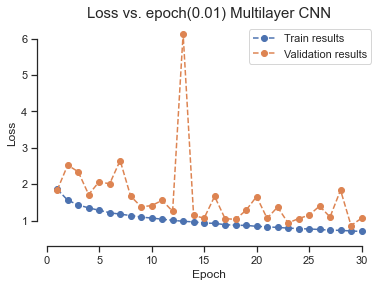

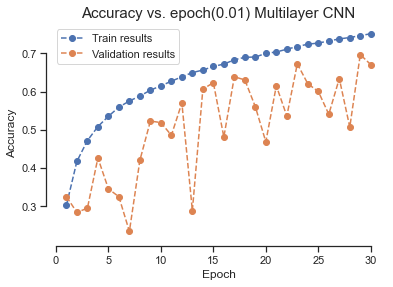

In [21]:
plot('Loss vs. epoch(0.01) Multilayer CNN', 'Loss', train_loss, val_loss)
plot('Accuracy vs. epoch(0.01) Multilayer CNN', 'Accuracy', train_accuracy, val_accuracy)

In [22]:
print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy)

Max Accuracy = 0.7515, Epoch= 29
Min Loss = 0.7012446454376172, Epoch= 29


## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

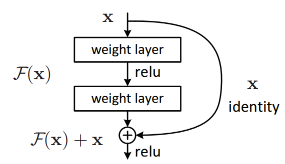

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**1. Skip connection addresses the degradation problem in a model, i.e. when the model gets deeper, it becomes more difficult for the layers to propagate the information from shallow layers and the information is lost**<br/>
**2. Due to the fact that some layers are not involved in training of the model hence they act as a residue in this scenario.**<br/>
**3. Training Larger networks where there is a higher chance of some gradients to be neglected due to its insignificant effect.**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

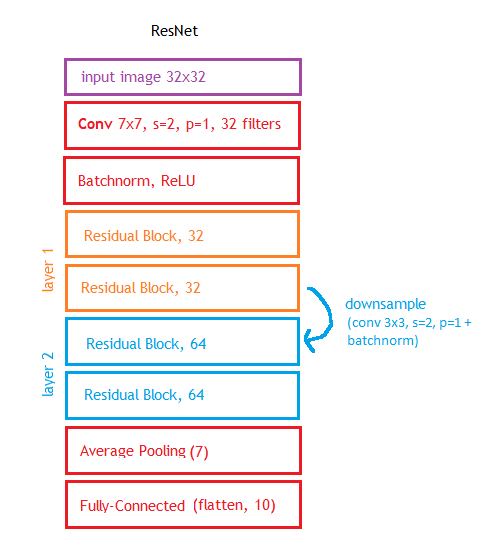 
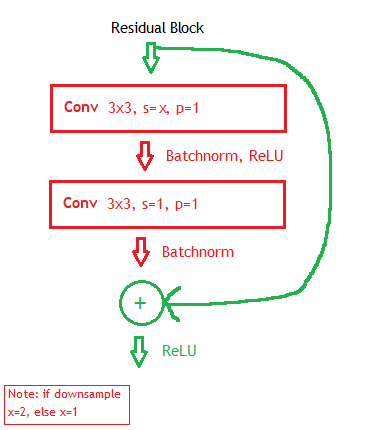

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [23]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [24]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        
        self.inplanes = 32

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)         

        x = self.layer1(x)          
        x = self.layer2(x)          

        x = self.avgpool(x)         
        x = torch.flatten(x, 1)      
        x = self.fc(x)

        return x

In [25]:
# TODO train and plot
resnet = ResNet(ResidualBlock, [2, 2]).to(device)
epochs = 30
lr = 0.1
optimizer = torch.optim.SGD(resnet.parameters(), lr = lr)
loss_function = torch.nn.CrossEntropyLoss()

In [26]:
train_loss, val_loss, train_accuracy, val_accuracy, confusion_matrix = run_training(model=resnet, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader)

Finished training after 409 seconds.


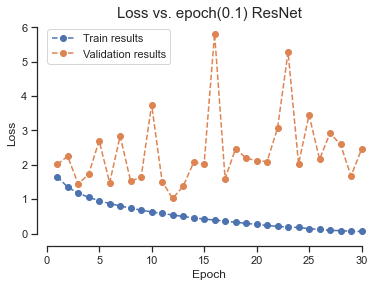

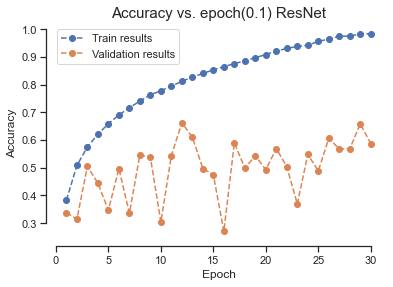

In [27]:
plot('Loss vs. epoch(0.1) ResNet', 'Loss', train_loss, val_loss)
plot('Accuracy vs. epoch(0.1) ResNet', 'Accuracy', train_accuracy, val_accuracy)

In [28]:
print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy)

Max Accuracy = 0.98395, Epoch= 29
Min Loss = 0.06107332822006599, Epoch= 29


#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**1. Yes the performance improved, as for similar learning rate and epochs the Resnet proves to be about 25% more accurate as compared to Multi layer CNN**<br/>
**2. Resnet model trained about 33% faster than Multi layer CNN**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

<b>

* 1. learning rate was reduced to initial/1e-1 in each epoch.<br/>
  2. Since the learning rate reduces exponentially, hence the model is stuck in a local maxima after a few initial epochs<br/>
* 1. learning rate was reduced by .9*initial in each epoch.<br/>
  2. The model keeps improving significantly with each epoch.</br>
* An optimal gamma ensures that the model neither gets converged quickly nor get stick in a local minima. 
</b>

In [29]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)
def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader,step_size=1, gamma=0.1, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    count=1
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        print("Epoch : {}, Learning Rate : {}".format(count, scheduler.get_last_lr()))

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            early_stopper.early_stop = [epoch_val_acc, model]
            if early_stopper.early_stop is True:
              break
            # raise NotImplementedError

            # END OF YOUR CODE #
        count+=1
        scheduler.step()
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


In [30]:
# TODO train and plot with step size 1, gamma 0.1
resnet = ResNet(ResidualBlock, [2, 2]).to(device)
epochs = 10
lr = 0.1
optimizer = torch.optim.SGD(resnet.parameters(), lr = lr)
loss_function = torch.nn.CrossEntropyLoss()
train_loss, val_loss, train_accuracy, val_accuracy, confusion_matrix = run_training(model=resnet, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader,step_size=1, gamma = 0.1)


Epoch : 1, Learning Rate : [0.1]
Epoch : 2, Learning Rate : [0.010000000000000002]
Epoch : 3, Learning Rate : [0.0010000000000000002]
Epoch : 4, Learning Rate : [0.00010000000000000003]
Epoch : 5, Learning Rate : [1.0000000000000004e-05]
Epoch : 6, Learning Rate : [1.0000000000000004e-06]
Epoch : 7, Learning Rate : [1.0000000000000005e-07]
Epoch : 8, Learning Rate : [1.0000000000000005e-08]
Epoch : 9, Learning Rate : [1.0000000000000005e-09]
Epoch : 10, Learning Rate : [1.0000000000000006e-10]
Finished training after 145 seconds.


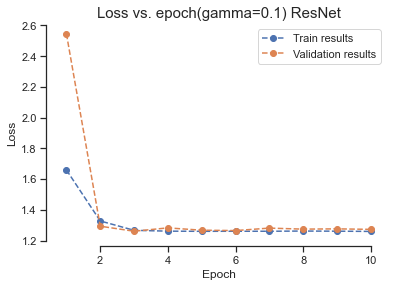

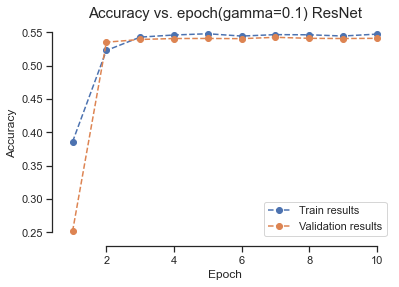

Max Accuracy = 0.548075, Epoch= 4
Min Loss = 1.259496953077377, Epoch= 9


In [31]:
# TODO train and plot with step size 1, gamma 0.9
plot('Loss vs. epoch(gamma=0.1) ResNet', 'Loss', train_loss, val_loss)
plot('Accuracy vs. epoch(gamma=0.1) ResNet', 'Accuracy', train_accuracy, val_accuracy)

print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy)

In [32]:
resnet = ResNet(ResidualBlock, [2, 2]).to(device)
epochs = 10
lr = 0.1
optimizer = torch.optim.SGD(resnet.parameters(), lr = lr)
loss_function = torch.nn.CrossEntropyLoss()
train_loss, val_loss, train_accuracy, val_accuracy, confusion_matrix = run_training(model=resnet, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader,step_size=1, gamma = 0.9)

Epoch : 1, Learning Rate : [0.1]
Epoch : 2, Learning Rate : [0.09000000000000001]
Epoch : 3, Learning Rate : [0.08100000000000002]
Epoch : 4, Learning Rate : [0.07290000000000002]
Epoch : 5, Learning Rate : [0.06561000000000002]
Epoch : 6, Learning Rate : [0.05904900000000002]
Epoch : 7, Learning Rate : [0.05314410000000002]
Epoch : 8, Learning Rate : [0.04782969000000002]
Epoch : 9, Learning Rate : [0.043046721000000024]
Epoch : 10, Learning Rate : [0.03874204890000002]
Finished training after 117 seconds.


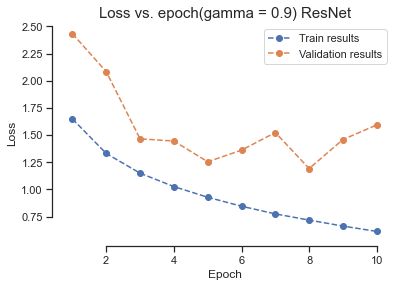

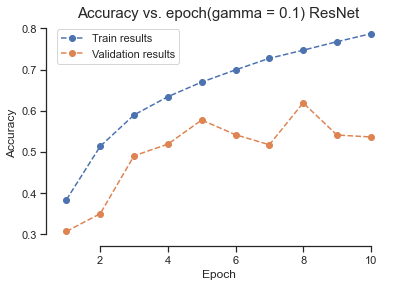

Max Accuracy = 0.78725, Epoch= 9
Min Loss = 0.613191899790126, Epoch= 9


In [33]:
plot('Loss vs. epoch(gamma = 0.9) ResNet', 'Loss', train_loss, val_loss)
plot('Accuracy vs. epoch(gamma = 0.1) ResNet', 'Accuracy', train_accuracy, val_accuracy)

print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy)

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**1. No the accuracy has decreased from 0.98395 to 0.603725**</br>
**2. After certain initial epochs the accuracy stops increasing significantly.**

**As stated by paper**</br>
<i>The learning rate
starts from 0.1 and is divided by 10 when the error plateaus,
and the models are trained for up to 60 ×10<sup>4</sup> iterations. We
use a weight decay of 0.0001 and a momentum of 0.9</i>

In [34]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.
resnet = ResNet(ResidualBlock, [2, 2]).to(device)
epochs = 30
lr = 0.1
optimizer = torch.optim.SGD(resnet.parameters(), lr = lr, weight_decay=0.0001, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()
train_loss, val_loss, train_accuracy, val_accuracy, confusion_matrix = run_training(model=resnet, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs= epochs, train_dataloader=trainloader, val_dataloader=valloader,step_size=1, gamma = 0.1)


Epoch : 1, Learning Rate : [0.1]
Epoch : 2, Learning Rate : [0.010000000000000002]
Epoch : 3, Learning Rate : [0.0010000000000000002]
Epoch : 4, Learning Rate : [0.00010000000000000003]
Epoch : 5, Learning Rate : [1.0000000000000004e-05]
Epoch : 6, Learning Rate : [1.0000000000000004e-06]
Epoch : 7, Learning Rate : [1.0000000000000005e-07]
Epoch : 8, Learning Rate : [1.0000000000000005e-08]
Epoch : 9, Learning Rate : [1.0000000000000005e-09]
Epoch : 10, Learning Rate : [1.0000000000000006e-10]
Epoch : 11, Learning Rate : [1.0000000000000006e-11]
Epoch : 12, Learning Rate : [1.0000000000000006e-12]
Epoch : 13, Learning Rate : [1.0000000000000007e-13]
Epoch : 14, Learning Rate : [1.0000000000000008e-14]
Epoch : 15, Learning Rate : [1.0000000000000009e-15]
Epoch : 16, Learning Rate : [1.000000000000001e-16]
Epoch : 17, Learning Rate : [1.000000000000001e-17]
Epoch : 18, Learning Rate : [1.000000000000001e-18]
Epoch : 19, Learning Rate : [1.000000000000001e-19]
Epoch : 20, Learning Rate : 

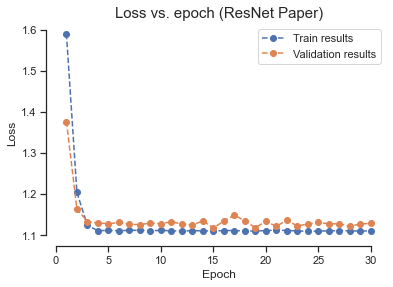

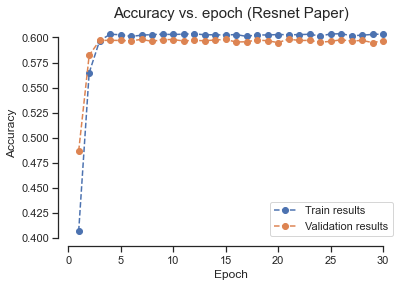

Max Accuracy = 0.603725, Epoch= 25
Min Loss = 1.1092140351890758, Epoch= 23


In [35]:
plot('Loss vs. epoch (ResNet Paper)', 'Loss', train_loss, val_loss)
plot('Accuracy vs. epoch (Resnet Paper)', 'Accuracy', train_accuracy, val_accuracy)

print_accuracy_loss(train_loss, val_loss, train_accuracy, val_accuracy)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [36]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [37]:
# TODO do transfer learning with resnet on cifar10